In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import harmonypy as hm
from modules.visualize import *
from modules.deg_analysis import *

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-17 14:53:09.437648: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-17 14:53:10.168428: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
sample_tag_mapping = {'SampleTag17_flex':'WT-DMSO',
                      'SampleTag18_flex':'3xTg-DMSO',
                      'SampleTag19_flex':'WT-SCDi',
                      'SampleTag20_flex':'3xTg-SCDi',
                      'Undetermined':'Undetermined',
                      'Multiplet':'Multiplet'}
# Load h5ad object
adata = anndata.read_h5ad("data/fede_count.h5ad")
# Map appropriate condition tags
adata.obs['Sample_Tag'] = adata.obs['Sample_Tag'].map(sample_tag_mapping)

# Load cell annotation info
anno_df = pd.read_csv("data/fede_mapping.csv", skiprows=4)
anno_df = anno_df.set_index('cell_id')[['class_name', "subclass_name", "supertype_name", 'cluster_name']]

In [2]:
adata1 = anndata.read_h5ad("data/A_count.h5ad")
adata1.obs['Sample_Tag'] = 'LD_5xFAD'
adata2 = anndata.read_h5ad("data/B_count.h5ad")
adata2.obs['Sample_Tag'] = "LD_NC"
adata3 = anndata.read_h5ad("data/C_count.h5ad")
adata3.obs['Sample_Tag'] = "run_5xFAD"
adata4 = anndata.read_h5ad("data/D_count.h5ad")
adata4.obs['Sample_Tag'] = "run_NC"
adata = anndata.concat([adata1, adata2, adata3, adata4], axis=0)
adata.obs.index = adata.obs.index.astype('str')

anno_df1 = pd.read_csv("data/A_mapping.csv", skiprows=4)
anno_df2 = pd.read_csv("data/B_mapping.csv", skiprows=4)
anno_df3 = pd.read_csv("data/C_mapping.csv", skiprows=4)
anno_df4 = pd.read_csv("data/D_mapping.csv", skiprows=4)
anno_df = pd.concat([anno_df1, anno_df2, anno_df3, anno_df4])
anno_df = anno_df.set_index('cell_id')[['class_name']]
anno_df.index = anno_df.index.astype('str')

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
# Initial QC and filtering
sc.pp.filter_cells(adata, min_genes=150)
sc.pp.filter_genes(adata, min_cells=3)

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [4]:
# Calculate mitochondrial genes percentage
adata.var['mt'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata.obs['high_mt'] = adata.obs['pct_counts_mt'] > 50

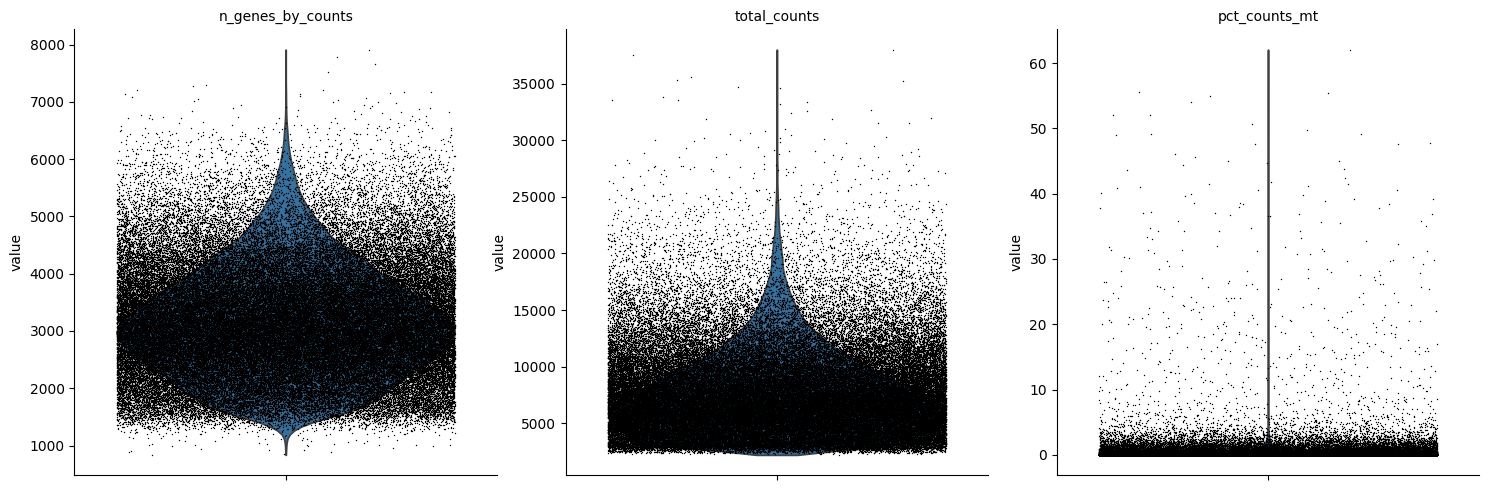

In [5]:
# Plot QC metrics
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True, save='violin.png')

In [6]:
# Filter cells
adata = adata[(adata.obs.pct_counts_mt < 5), :]
#adata = adata[:, ~adata.var['mt']]

In [ ]:
# Filter multiplets if applicable (assuming Sample_Name is a column in adata.obs)
adata = adata[adata.obs['Sample_Name'] != "Multiplet", :]
#adata = adata[adata.obs['Sample_Name'] != "Undetermined", :]

In [7]:
# Saving raw counts before data transformation
adata.raw = adata

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [8]:
# Preprocess the data: Normalization, log-transformation, and scaling
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True)
sc.pp.scale(adata)

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


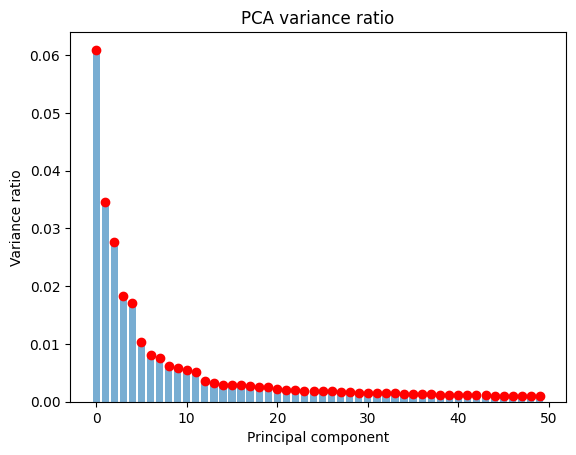

In [9]:
# Plot explained variance vs PCs
elbow_plot(adata)

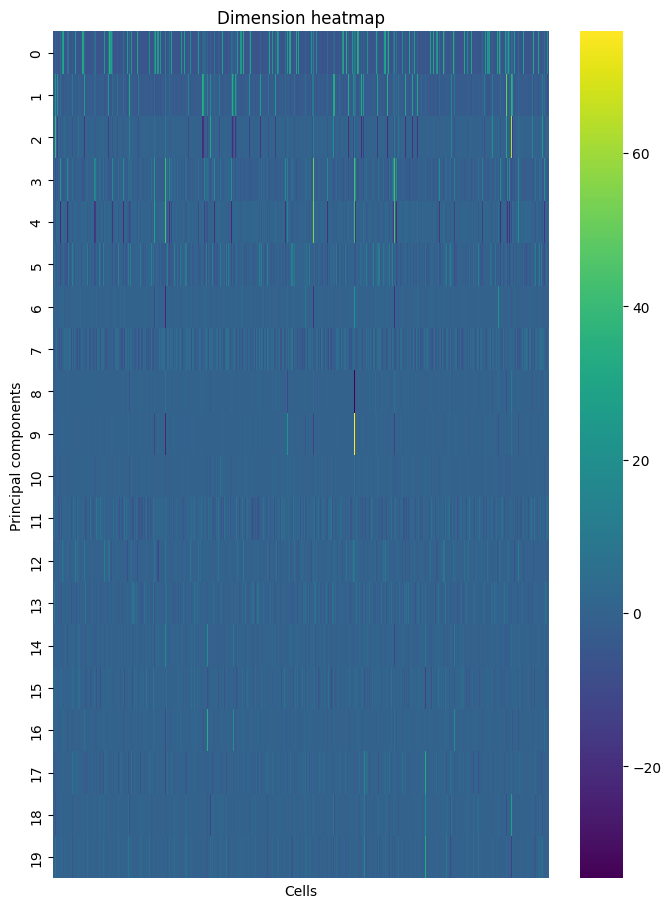

In [10]:
# Dimension heatmap
dimension_heatmap(adata, n_components=20, n_cells=500)

In [11]:
# PCA with optimal n_comps
sc.tl.pca(adata, n_comps=10)

# Harmony batch correction
harmony_out = hm.run_harmony(adata.obsm['X_pca'], adata.obs, 'Sample_Tag')
adata.obsm['X_pca_harmony'] = harmony_out.Z_corr.T

# Neighbors and clustering using Harmony-corrected PCA
sc.pp.neighbors(adata, use_rep='X_pca_harmony', n_pcs=10)
sc.tl.leiden(adata, resolution=0.5)

# UMAP and t-SNE
sc.tl.umap(adata)
sc.tl.tsne(adata)

2024-06-17 14:55:43,296 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-06-17 14:55:47,834 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-06-17 14:55:48,087 - harmonypy - INFO - Iteration 1 of 10
2024-06-17 14:56:05,611 - harmonypy - INFO - Iteration 2 of 10
2024-06-17 14:56:10,550 - harmonypy - INFO - Iteration 3 of 10
2024-06-17 14:56:15,540 - harmonypy - INFO - Iteration 4 of 10
2024-06-17 14:56:20,333 - harmonypy - INFO - Iteration 5 of 10
2024-06-17 14:56:25,237 - harmonypy - INFO - Converged after 5 iterations
/tmp/ipykernel_35128/3555927198.py:10: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5)


KeyboardInterrupt: 

In [ ]:
# Plotting
sc.pl.umap(adata, color=['leiden'], save='umap_leiden.png')
sc.pl.umap(adata, color=['Sample_Tag'], save='umap_sampletag.png')
sc.pl.umap(adata, color=['high_mt'], save='umap_highmt.png')

In [ ]:
#sc.pl.tsne(adata, color=['leiden'], save='tsne_leiden.png')
#sc.pl.tsne(adata, color=['Sample_Tag'], save='tsne_sampletag.png')
#sc.pl.tsne(adata, color=['high_mt'], save='tsne_highmt.png')

In [ ]:
adata = adata[adata.obs['Sample_Name'] != "Undetermined", :]

In [ ]:
adata = adata[(adata.obs.pct_counts_mt < 50), :]

In [ ]:
# Plotting
sc.pl.umap(adata, color=['leiden'], save='umap_leiden_nound_nohighmt.png')
sc.pl.umap(adata, color=['Sample_Tag'], save='umap_sampletag_nound_nohighmt.png')

In [ ]:
adata.obs['cell_id'] = adata.obs.index.astype(str)
anno_df.index = anno_df.index.astype(str)
adata.obs = adata.obs.merge(anno_df, left_on='cell_id', right_index=True, how='left')
# Assign unique cell type names to each cluster
assign_unique_cell_type_names(adata)
# Ensure leiden and annotated_cluster are strings for concatenation
adata.obs['leiden'] = adata.obs['leiden'].astype(str)
adata.obs['annotated_cluster'] = adata.obs['annotated_cluster'].astype(str)

In [ ]:
# Plot UMAP with unique cell type annotations
sc.pl.umap(adata, color=['annotated_cluster'], save='umap_all_groups.png', title=f'After QC - {adata.shape[0]} cells', size=10)

In [ ]:
sample_tags = adata.obs['Sample_Tag'].unique()
plot_umap(adata, sample_tags, legend_fontsize=7)

In [ ]:
sample_tag_counts = get_master_table(adata)

In [ ]:
create_ditto_plot(adata, ['WT-DMSO', '3xTg-DMSO', 'WT-SCDi', '3xTg-SCDi', 'Undetermined'], min_cell=100)

In [ ]:
create_ditto_plot(adata, ['WT-DMSO'], min_cell=100)
create_ditto_plot(adata, ['3xTg-DMSO'], min_cell=100)
create_ditto_plot(adata, ['WT-SCDi'], min_cell=100)
create_ditto_plot(adata, ['3xTg-SCDi'], min_cell=100)

In [ ]:
#ctr, cnd = 'WT-DMSO', '3xTg-DMSO'
ctr, cnd = 'WT-DMSO', 'WT-SCDi'

In [ ]:
cell_types = [x for x in set(adata.obs.annotated_cluster.values)]

In [ ]:
cluster_n_DEGs = []
min_fold_change = 0.5
max_p_value = 0.01
for cell_type in tqdm(cell_types):
    df = DEG_analysis(adata, ctr, cnd, [cell_type])
    if df is None:
        continue
    positive_enriched = df[(df['logfoldchanges'] > min_fold_change) & (df['pvals_adj'] < max_p_value)]
    negative_enriched = df[(df['logfoldchanges'] < -min_fold_change) & (df['pvals_adj'] < max_p_value)]
    positive_count = positive_enriched.shape[0]
    negative_count = negative_enriched.shape[0]
    cluster_n_DEGs.append((cell_type, positive_count, negative_count))

In [ ]:
horizontal_deg_chart(cluster_n_DEGs, 'wt_dmso_vs_wt_scdi')

In [ ]:
results_df = DEG_analysis(adata, ctr, cnd, cell_types)

In [ ]:
get_volcano_plot(results_df, 'wt_dmso_vs_wt_scdi', min_fold_change=0.5, max_p_value=0.01)

In [ ]:
get_heatmap(adata, 'WT-DMSO', 'WT-SCDi', 'wt_dmso_vs_wt_scdi', results_df, display_top_n=50, min_fold_change=0.5, max_p_value=0.05)

In [ ]:
pos_DEGs = [x['names'] for x in results_df.T.to_dict().values() if x['logfoldchanges'] > 0.5 and x['pvals_adj'] < 0.05]
neg_DEGs = [x['names'] for x in results_df.T.to_dict().values() if x['logfoldchanges'] < -0.5 and x['pvals_adj'] < 0.05]

In [ ]:
gene_list_ncbi, background_genes_ncbi = query_genes(neg_DEGs, adata)
go_results = perform_go_enrichment(gene_list_ncbi, background_genes_ncbi)

In [ ]:
#BP, MF or CC
display_go_enrichment(go_results, 'negative_DEG_wt_dmso_vs_wt_scdi', namespace='BP')